### Hand Writting

In [2]:
# Import necessary tools
import gzip
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.2.0
TF Hub version: 0.8.0
GPU available (YESSSS!!!!!)


### Getting our data ready (turning into Tensors)


In [3]:
def training_images():
    with gzip.open('/content/drive/My Drive/Hand Writing/data/train-images.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('/content/drive/My Drive/Hand Writing/data/train-labels.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels
        

In [ ]:
X_train=training_images()
X_train.shape

In [ ]:

ytrain=training_labels()
ytrain.shape[0]

60000

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
X_test=test_images()
X_test.shape[0]

10000

In [ ]:
ytest=test_labels()
ytest.shape

(10000,)

In [ ]:
print("Training set images shape: {}".format(X_train.shape))
print("Training set labels shape: {}".format(ytrain.shape))
print("Test set images shape: {}".format(X_test.shape))
print("Test set labels shape: {}".format(ytest.shape))

Training set images shape: (60000, 28, 28)
Training set labels shape: (60000,)
Test set images shape: (10000, 28, 28)
Test set labels shape: (10000,)


In [ ]:
X_train[2000]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  94, 163,
         99, 228, 255, 202,  49,  58,  47,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

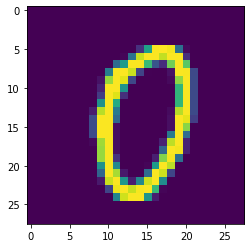

In [ ]:
import matplotlib.pyplot as plt
img = X_train[1000]
plt.imshow(img);

In [ ]:
print("Max Value: {}\nMin Value: {}".format(np.max(img), np.min(img)))


Max Value: 255
Min Value: 0


In [ ]:
train_X = X_train.reshape(-1, 28, 28, 1)
test_X = X_test.reshape(-1, 28, 28, 1)
print("Train Shape: {}\nTest Shape: {}".format(train_X.shape, test_X.shape))

Train Shape: (60000, 28, 28, 1)
Test Shape: (10000, 28, 28, 1)


In [ ]:
train_X[0].shape

(28, 28, 1)

In [ ]:
# fin the unique values labels
unique_breeds=np.unique(ytrain)
len(unique_breeds)

10

In [ ]:
print(ytrain[0])
ytrain[0] == unique_breeds

5


array([False, False, False, False, False,  True, False, False, False,
       False])

In [ ]:
labels=ytrain
len(labels)

60000

In [ ]:
# Turn every label into a boolean array
boolean_labels=[label==unique_breeds for label in labels ]

In [ ]:
boolean_labels[:3]

[array([False, False, False, False, False,  True, False, False, False,
        False]),
 array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([False, False, False, False,  True, False, False, False, False,
        False])]

In [ ]:
len(boolean_labels)

60000

In [ ]:
# turning boolean array to numbers
print(labels[0])
print(np.where(unique_breeds==labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

5
(array([5]),)
5
[0 0 0 0 0 1 0 0 0 0]


In [ ]:
print(labels[10])
print(boolean_labels[10].astype(int))

3
[0 0 0 1 0 0 0 0 0 0]


### Creating our own validation set

In [ ]:
# Setup X & y variables
X = X_train
y = boolean_labels

In [ ]:
len(y)

60000

In [ ]:
NUM_IMG=1000 #@param {type:'slider',min:1000,max:10000,step:1000}

In [ ]:
# split our data
from sklearn.model_selection import train_test_split
xtrain,xvalid,ytrain,yvalid=train_test_split(X[:NUM_IMG],
                                             y[:NUM_IMG],
                                             test_size=0.20,
                                             random_state=42)

In [ ]:
len(xtrain),len(ytrain),len(xvalid),len(yvalid)

(800, 800, 200, 200)

In [ ]:
##xtrain[5],ytrain[5]

In [ ]:
tf.constant(img)[:2]

<tf.Tensor: shape=(2, 28), dtype=uint8, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE=224

In [ ]:
def process_image(image_path,img_size=IMG_SIZE):
   """
  Takes an image file path and turns the image into a Tensor.
  """
 
  # Resize the image to our desired value (224, 224)
   image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

   return image

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image=process_image(image_path)
  return image,label

In [ ]:
 tf.constant(ytrain[42])

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False,  True, False, False, False,
       False])>

In [ ]:
tf.constant(xtrain[42])

<tf.Tensor: shape=(28, 28), dtype=uint8, numpy=
array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  91, 243,
        130,  45,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 118, 254,
        254, 240,  59,   0,   0,   0,   0,   0,   0,  

In [ ]:
BATCH_SIZE = 32


In [ ]:
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch
 

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(xtrain, ytrain)
val_data = create_data_batches(xvalid, yvalid, valid_data=True)

Creating training data batches...


StagingError: ignored

In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)))

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(10):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
unique_breeds[y[0].argmax()]

5

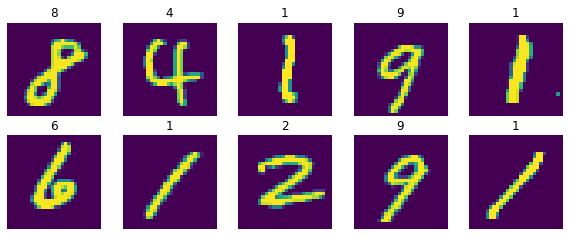

In [ ]:
# # Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator()) # turn into numpy
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub
 - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
IMG_SIZE

28

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, 28, 28, 1] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
OUTPUT_SHAPE

10

In [ ]:
INPUT_SHAPE

[None, 28, 28, 1]

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model=create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


ValueError: ignored

In [ ]:
NUM_EPOCHS=100 #@param {type:'slider',min:10,max:100,steps:10}

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
import os

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Hand Writing/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
# Build a function to train and return a trained model

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model

  model=create_model()
  # Create new TensorBoard session everytime we train a model
  tensorboard=create_tensorboard_callback()
  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  # Return the fitted model

  return model




In [ ]:
model=train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


ValueError: ignored